**Assignments 2&3 - Deep Learning**

Antonakaki Eleni

Lt1200002

Master Language Technology

RNN MODEL - LSTM BIDIRECTIONAL

In [ ]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from tqdm import tqdm
import spacy
import string
import re
import nltk
import torch
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
from torch import optim
import torchtext 
import pickle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from wordcloud import WordCloud
import random

random.seed(10)

In [ ]:
nltk.download('stopwords')
stopwords = set(stopwords.words("english"))
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**1. Set device**

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")

torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print (device)

cuda


In [ ]:
#loading the data
reviews = pd.read_csv("IMDB_reviews.csv")
print(reviews.shape)

reviews.head()

(50000, 2)


,review,sentiment
0,"Someone(or, something thing..)is leaving punct...",positive
1,Beginning with the poster (featuring only Morg...,negative
2,This movie is one of the most awful movies eve...,negative
3,Generally political messages are done on telev...,negative
4,I'm surprised at the comments from posters sta...,positive


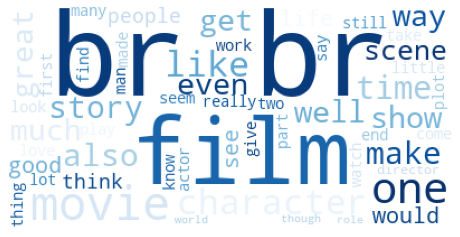

In [ ]:
def plot_wordcloud(review, cmap):
    fig, ax = plt.subplots(figsize=(8, 6))
    wc = WordCloud(max_words = 1000, background_color ='white', stopwords = stopwords, 
                   min_font_size = 10, colormap=cmap)
    wc = wc.generate(review)
    plt.axis('off')
    plt.imshow(wc)

# word cloud on positve reviews
pos_rev = ' '.join(reviews[reviews['sentiment']=='positive']['review'].to_list()[:10000])
plot_wordcloud(pos_rev, 'Blues')

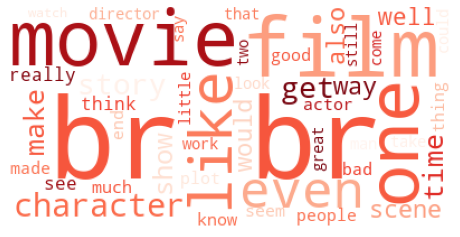

In [ ]:
# word cloud on negative reviews
neg_rev = ' '.join(reviews[reviews['sentiment']=='negative']['review'].to_list()[:10000])
plot_wordcloud(neg_rev, 'Reds')

In [ ]:
#Convert categorical data into numerical 
# 1 for "positive", 0 for "negative"
le = LabelEncoder()
label = le.fit_transform(reviews['sentiment'])
reviews['label'] = label

reviews = reviews.drop('sentiment', 1)
reviews.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


,review,label
0,"Someone(or, something thing..)is leaving punct...",1
1,Beginning with the poster (featuring only Morg...,0
2,This movie is one of the most awful movies eve...,0
3,Generally political messages are done on telev...,0
4,I'm surprised at the comments from posters sta...,1


label
0    25000
1    25000
dtype: int64


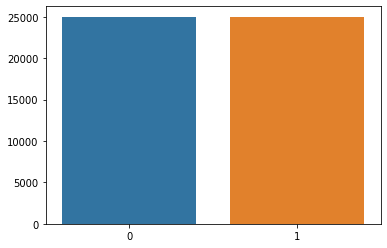

In [ ]:
#analysing labels
print(reviews.groupby(['label']).size())

dd = pd.Series(reviews['label']).value_counts()
sns.barplot(x=np.array(['0','1']),y= dd.values)
plt.show()

**3. Processing**

1. remove punctuation
2. remove emoticons
3. lowercasing
4. remove stopwords
5. Porter Stemmer

In [ ]:
#process data
reviews['review'].fillna('')

def preprocess_text(text):
                
        TAG_RE = re.compile(r'<[^>]+>_-@')
        no_tags = TAG_RE.sub('',text) 
        text = re.sub('<[^>]*>_@-', '', no_tags)        
        text = re.sub('_','',text) 
        emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
        text = re.sub('[\W]+', ' ', text.lower()) + " ".join(emoticons).replace('-', '')
        text = re.sub(r'\d+', '', text)

        return text

def remove_stopwords(text):

    text = nltk.word_tokenize(text)
    text = [w for w in text if not w in stopwords]
    text= ' '.join(text)
      
    return text



stemming = PorterStemmer()
def porterstemmer(text):
    return " ".join([stemming.stem(w) for w in text])


In [ ]:
#process on data
reviews['review']=reviews['review'].apply(preprocess_text)
reviews['review']=reviews['review'].apply(remove_stopwords)
#reviews['review']= reviews['review'].apply(porterstemmer).copy()

reviews.head()

,review,label
0,someone something thing leaving puncture marks...,1
1,beginning poster featuring morgan freeman kevi...,0
2,movie one awful movies ever made jon bon jovi ...,0
3,generally political messages done television b...,0
4,surprised comments posters stating jane powell...,1


In [ ]:
X = reviews['review']
Y = reviews['label']

# Split dataset to train and test set.
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.1, random_state = 1)

# Split train dataset to train and validation set.
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state = 1)

print("X_train's shape:", X_train.shape)
print("Y_train's shape:", Y_train.shape)
print("X_val's shape:", X_val.shape)
print("Y_val's shape:", Y_val.shape)
print("X_test's shape:", X_test.shape)
print("Y_test's shape:", Y_test.shape)

X_train's shape: (40500,)
Y_train's shape: (40500,)
X_val's shape: (4500,)
Y_val's shape: (4500,)
X_test's shape: (5000,)
Y_test's shape: (5000,)


In [ ]:
#concatenate reviews and labels into a dataframe
df_train = pd.concat([X_train, Y_train], axis=1)
print(df_train.shape)

df_test = pd.concat([X_test, Y_test], axis=1)
print(df_test.shape)

df_valid = pd.concat([X_val, Y_val], axis=1)
print(df_valid.shape)

#save dataframes as ".csv" files
#os.mkdir('dataset')
df_train.to_csv("./dataset/train.csv", index=False)
df_test.to_csv("./dataset/test.csv", index=False)
df_valid.to_csv("./dataset/valid.csv", index=False)

df_train.head()

(40500, 2)
(5000, 2)
(4500, 2)


,review,label
28031,movie amazing never laugh harder target think ...,1
20911,excellent little known movie tom selleck outst...,1
23209,child eighties like probably remember disney m...,1
47822,great addition anyone collection br br monkeys...,1
41184,movies oscar worthy let face sometimes types m...,1


**Use torchtext library for dataset and build vocab**

> *Field* for preprocessing

> *TabularDataset* for loading the train,validation and test data (csv file)

> *BucketIterator* for batching and padding

In [ ]:
#calculate mean and maximum sequence length of train dataset

reviews_list=[]
for x in df_train['review']:
  reviews_list.append(x)

print(np.max([len(x) for x in reviews_list]))
print(np.mean([len(x) for x in reviews_list]))
#print(len(reviews_list[1]))

9222
828.2459259259259


In [ ]:
TEXT = torchtext.legacy.data.Field(tokenize='spacy', include_lengths=True) # packed_padded_sequence
LABEL = torchtext.legacy.data.LabelField(dtype=torch.float)

In [ ]:
train_data, valid_data, test_data = torchtext.legacy.data.TabularDataset.splits( 
    path="/content/dataset/", 
    train="train.csv", 
    validation="valid.csv",
    test= "test.csv", 
    format="csv", 
    skip_header=True, 
    fields=[('text', TEXT), ('label', LABEL)])

print(f'Number of training samples: {len(train_data)}')
print(f'Number of validation samples: {len(valid_data)}')
print(f'Number of test samples: {len(test_data)}')

Number of training samples: 40500
Number of validation samples: 4500
Number of test samples: 5000


In [ ]:
#VOCABULARY_SIZE + 2 for <unk> and <pad>
TEXT.build_vocab(train_data, max_size= 30000, vectors='glove.6B.100d', unk_init=torch.Tensor.normal_)
LABEL.build_vocab(train_data)

print(f'Vocabulary size: {len(TEXT.vocab)}')
print(f'Number of classes: {len(LABEL.vocab)}')

Vocabulary size: 30002
Number of classes: 2


In [ ]:
BATCH_SIZE = 64
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_loader, valid_loader, test_loader = torchtext.legacy.data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True, # necessary for packed_padded_sequence
    device=DEVICE)

# Print number of batches per dataset.
print('Created `train_iterator` with %d batches!'%len(train_loader))
print('Created `valid_iterator` with %d batches!'%len(valid_loader))
print('Created `test_iterator` with %d batches!'%len(test_loader))

Created `train_iterator` with 633 batches!
Created `valid_iterator` with 71 batches!
Created `test_iterator` with 79 batches!


In [ ]:
word_embeddings = TEXT.vocab.vectors.to(device)
#print(word_embeddings[2])

In [ ]:
class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
          
        embedded = self.embedding(text)

        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
                            
        return output

In [ ]:
# Hyperparameters
learning_rate = 0.001

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding

net = LSTM_net(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,  N_LAYERS,  BIDIRECTIONAL,  DROPOUT,  PAD_IDX)

print(net)

LSTM_net(
  (embedding): Embedding(30002, 100, padding_idx=1)
  (rnn): LSTM(100, 256, num_layers=2, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
net.embedding.weight.data.copy_(word_embeddings)
net.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
print(net.embedding.weight.data)

tensor([[ 0.1940,  2.1614, -0.1721,  ...,  0.2322,  1.1415, -0.6817],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1979,  0.2526, -0.2831,  ..., -0.4406, -0.7426, -0.3215],
        ...,
        [-0.4408, -0.0481, -0.7686,  ..., -1.4308,  0.1823, -0.7865],
        [-0.2218,  0.5407,  0.1583,  ..., -0.4790, -0.8845,  0.5652],
        [-0.0650, -0.0255, -0.3165,  ..., -0.1113, -0.4240, -0.0349]])


In [ ]:
net = net.to(DEVICE)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
# training function 
def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        text, text_lengths = batch.text
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        #print(predictions)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator):
    
    epoch_acc = 0
    epoch_loss = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, batch.label)

            acc = binary_accuracy(predictions, batch.label)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
train_loss=[]
valid_loss =[]
train_acc=[]
valid_acc=[]
num_epochs = 3
epoch =0

for epoch in range(num_epochs):
    
    train_l, train_a = train(net, train_loader)
    valid_l, valid_a = evaluate(net, valid_loader)
    epoch +=1
    
    torch.save(net.state_dict(), 'tut4-model.pt')
    
    train_loss.append(train_l)
    train_acc.append(train_a)
    valid_loss.append(valid_l)
    valid_acc.append(valid_a)

    
    print(f'EPOCH {epoch}: Train Loss: {train_l:.3f} | Train Acc: {train_a:.3f} | Val. Loss: {valid_l:.3f} | Validation Acc: {valid_a:.3f} ')

EPOCH 1: Train Loss: 0.554 | Train Acc: 0.687 | Val. Loss: 0.320 | Validation Acc: 0.867 
EPOCH 2: Train Loss: 0.349 | Train Acc: 0.815 | Val. Loss: 0.295 | Validation Acc: 0.892 
EPOCH 3: Train Loss: 0.280 | Train Acc: 0.847 | Val. Loss: 0.232 | Validation Acc: 0.904 


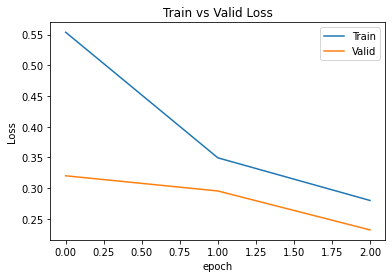

In [ ]:
plt.plot(train_loss)
plt.plot(valid_loss)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
 
plt.show()

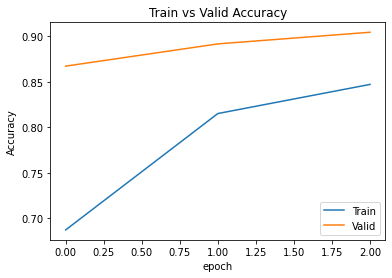

In [ ]:
plt.plot(train_acc)
plt.plot(valid_acc)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

**Predictions on test set**

1. confusion matrix
2. classification report

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [ ]:
def predictions(model, iterator):
    
    preds = []
    labels = []
    epoch_acc = 0
    epoch_loss = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            rounded_preds = torch.round(torch.sigmoid(predictions))

            acc = binary_accuracy(predictions, batch.label)
            preds.append(rounded_preds)

            labels.append(batch.label)
          
            epoch_acc += acc.item()

    return epoch_acc / len(iterator), preds, labels

In [ ]:
acc, predictions, labels = predictions(net, test_loader)

print("Test accuracy:", acc*100)

Test accuracy: 89.65585443037975


In [ ]:
#plot classification report 
actual=[]
preds = []
for i in predictions:
   for m in i:
      preds.append(m.float().cpu().detach().numpy())
for i in labels:
  for m in i:
    actual.append(m.float().cpu().detach().numpy())

class_report = classification_report(actual, preds)
print(class_report)

              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90      2478
         1.0       0.90      0.90      0.90      2522

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



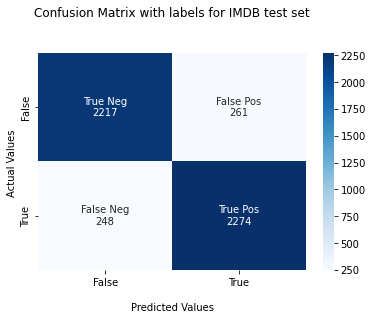

In [ ]:
#plot confusion matrix

conf_matrix = confusion_matrix(actual, preds)
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]


labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix with labels for IMDB test set\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()